In [15]:
import os
import pickle

def load_data(path):
    
    """   Load Dataset from File   """
    
    input_file=os.path.join(path)
    with open(input_file,"r") as f:
        data=f.read()
    return data

def preprocess_and_save_data(dataset_path,token_lookup,create_lookup_tables):
    
    """   Preprocess Text Data   """
    
    text=load_data(dataset_path)# Ignore notice, since we don't use it for analysing the data
    text=text[81:]
    token_dict=token_lookup()
    for key,token in token_dict.items():
        text= str(text).replace(key,' {} '.format(token))
        text=text.lower()
        text=text.split()
        vocab_to_int,int_to_vocab=create_lookup_tables(text)
        int_text=[vocab_to_int[word] for word in text]
        pickle.dump((int_text,vocab_to_int,int_to_vocab,token_dict),open('preprocess.p','wb'))
        
def load_preprocess():
    
    """   Load the Preprocessed Training 
    data and return them in batches 
    of <batch_size> or less   """
    
    return pickle.load(open('preprocess.p',mode='rb'))

def save_params(params):
    
    """   Save parameters to file   """
    
    pickle.dump(params,open('params.p','wb'))
    
def load_params():
    
    """   Load parameters from file   """
    
    return pickle.load(open('params.p',mode='rb'))

In [2]:
# Load data
data_dir='C:/Users/tmutengwa/Documents/Acadgild/moes_tavern_lines.txt'
text=load_data(data_dir)# Ignore notice, since we don't use it for analysing the data
text=text[81:]

### Explore the Data

#### Play around with view_sentence_range to view different parts of the data.

In [3]:
view_sentence_range = (0, 10)

#pay attention to the number of words in a sentence

import numpy as np

print('Dataset Stats')
print('Roughly the number of unique words: {}'.format(len({word: None for word in text.split()})))
scenes = text.split('\n\n')
print('Number of scenes: {}'.format(len(scenes)))
sentence_count_scene = [scene.count('\n') for scene in scenes]
print('Average number of sentences in each scene: {}'.format(np.average(sentence_count_scene)))

sentences = [sentence for scene in scenes for sentence in scene.split('\n')]
print('Number of lines: {}'.format(len(sentences)))
word_count_sentence = [len(sentence.split()) for sentence in sentences]
print('Average number of words in each line: {}'.format(np.average(word_count_sentence)))

print()
print('The sentences {} to {}:'.format(*view_sentence_range))
print('\n'.join(text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

Dataset Stats
Roughly the number of unique words: 11492
Number of scenes: 262
Average number of sentences in each scene: 15.248091603053435
Number of lines: 4257
Average number of words in each line: 11.501761804087385

The sentences 0 to 10:
on: Eh, yeah, hello, is Mike there? Last name, Rotch.
Moe_Szyslak: (INTO PHONE) Hold on, I'll check. (TO BARFLIES) Mike Rotch. Mike Rotch. Hey, has anybody seen Mike Rotch, lately?
Moe_Szyslak: (INTO PHONE) Listen you little puke. One of these days I'm gonna catch you, and I'm gonna carve my name on your back with an ice pick.
Moe_Szyslak: What's the matter Homer? You're not your normal effervescent self.
Homer_Simpson: I got my problems, Moe. Give me another one.
Moe_Szyslak: Homer, hey, you should not drink to forget your problems.
Barney_Gumble: Yeah, you should only drink to enhance your social skills.


Moe_Szyslak: Ah, isn't that nice. Now, there is a politician who cares.


### Implement Preprocessing Functions

The first thing to do to any dataset is preprocessing. Implement the following preprocessing functions below:


Lookup Table

Tokenize Punctuation

#### Lookup Table

To create a word embedding, you first need to transform the words to ids. In this function, create twodictionaries:

Dictionary to go from the words to an id, we'll call vocab_to_int

Dictionary to go from the id to word, we'll call int_to_vocab

Return these dictionaries in the following tuple (vocab_to_int, int_to_vocab)


### Solution

In [4]:
import numpy as np 
def create_lookup_tables(text):
    """   Create lookup tables for vocabulary:
    param text: The text of tv scripts split into words:
    return: A tuple of dicts (vocab_to_int, int_to_vocab)"""
    
    vocab=set(text)
    vocab_to_int={c:i for i,c in enumerate(vocab)}
    int_to_vocab=dict(enumerate(vocab))
    return vocab_to_int,int_to_vocab

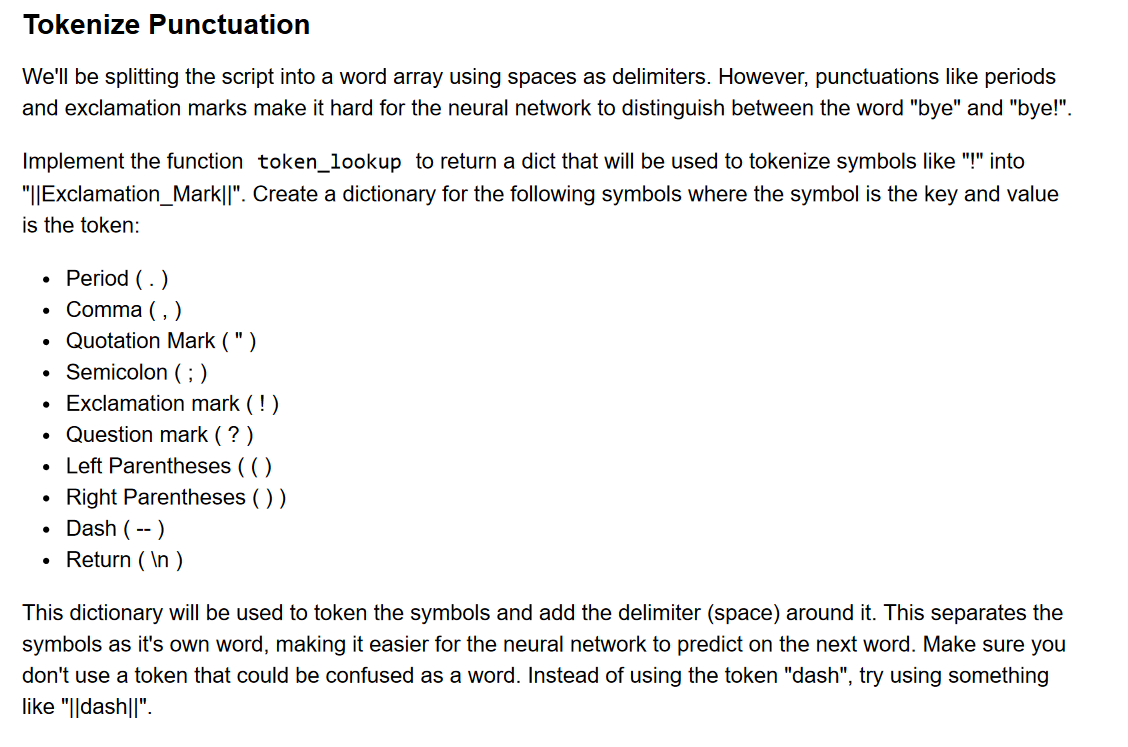

In [5]:
def token_lookup():
    """
    Generate a dict to turn punctuation into a token.
    :return: Tokenize dictionary where the key is the punctuation and the value is the token
    """
    # TODO: Implement Function
    values = ['||Period||','||Comma||','||Quotation_Mark||','||Semicolon||','||Exclamation_mark||','||Question_mark||','||Left_Parentheses||','||Right_Parentheses||','||Dash||','||Return||']
    keys = ['.', ',', '"', ';', '!', '?', '(', ')', '--','\n'] 
    token = dict(zip(keys,values))    
    return token

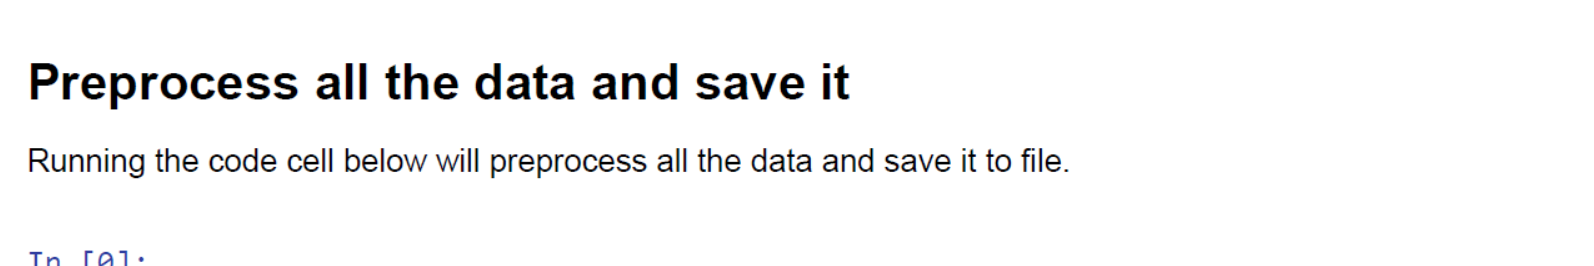

In [16]:
preprocess_and_save_data(data_dir, token_lookup, create_lookup_tables)

In [17]:
int_text,vocab_to_int,int_to_vocab,token_dict=load_preprocess()

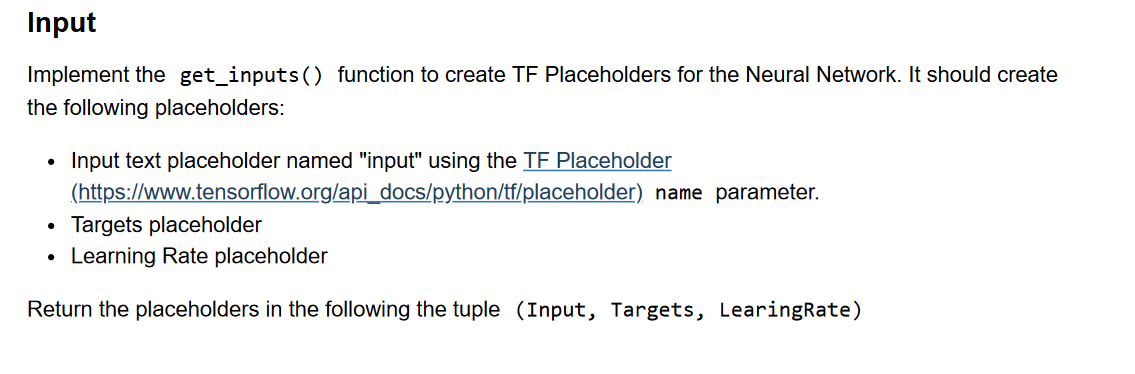

In [19]:
def get_inputs():
    
    """ 
    Create TF Placeholders for input, 
    targets, and learning rate.   
    :return: Tuple (input, targets, learning rate)
    """
   
    Input=tf.placeholder(tf.int32,[None,None],name='input')
    Targets=tf.placeholder(tf.int32,[None,None])
    LearningRate=tf.placeholder(tf.float32)
    return Input,Targets,LearningRate

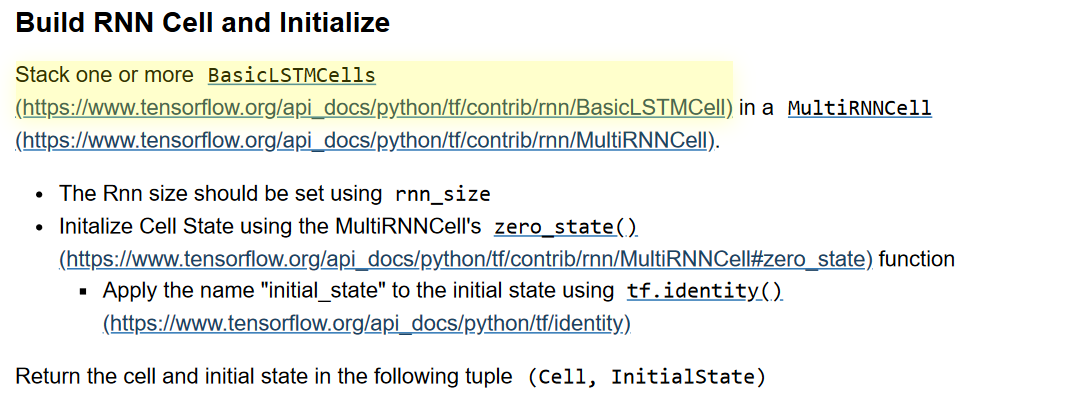

In [29]:
def get_init_cell(batch_size,rnn_size):
    """ 
    Create an RNN Cell and initialize it.
    :param batch_size: Size of batches
    :param rnn_size: Size of RNNs 
    :return: Tuple (cell, initial_state) 
    """
    
    lstm = tf.contrib.rnn.BasicLSTMCell(rnn_size)
    cell = tf.contrib.rnn.MultiRNNCell([lstm])
    initial_state = tf.identity(cell.zero_state(batch_size, tf.int32),name= 'initial_state')
     
    return cell, initial_state

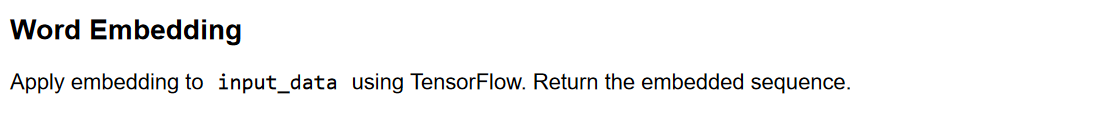

In [21]:
def get_embed(input_data, vocab_size, embed_dim):
    """
    Create embedding for <input_data>.
    :param input_data: TF placeholder for text input.
    :param vocab_size: Number of words in vocabulary.
    :param embed_dim: Number of embedding dimensions
    :return: Embedded input.
    """
    embedding = tf.Variable(tf.random_uniform((vocab_size, embed_dim), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, input_data)
    return embed

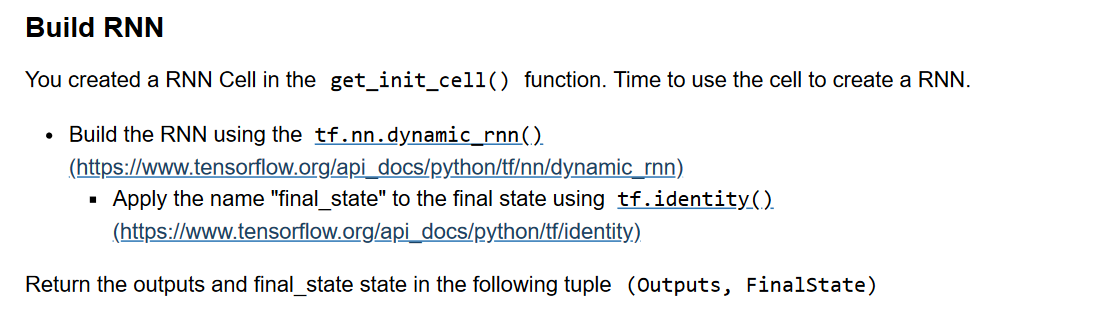

In [22]:
def build_rnn(cell, inputs):
    """
    Create a RNN using a RNN Cell
    :param cell: RNN Cell
    :param inputs: Input text data
    :return: Tuple (Outputs, Final State)
    """
    rnn, states = tf.nn.dynamic_rnn(cell, inputs,dtype='float32')
    final_state = tf.identity(states,name="final_state")
    return rnn, final_state

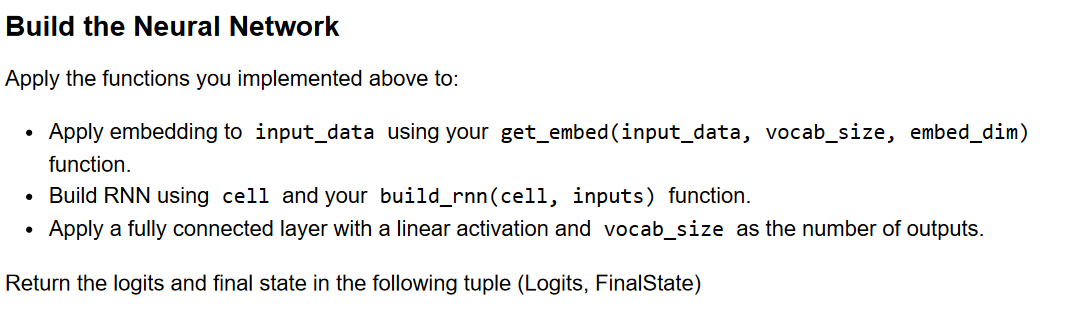

In [23]:
def build_nn(cell, rnn_size, input_data, vocab_size, embed_dim):
    embeddings = get_embed(input_data, vocab_size, embed_dim)
    inputs, final_state = build_rnn(cell, embeddings)
    logits = tf.contrib.layers.fully_connected(inputs=inputs, num_outputs=vocab_size, activation_fn=None)
    return logits, final_state

In [25]:
def get_batches(int_text,batch_size,seq_length):
    """ 
    Return batches of input and target 
    :param int_text: Text with the words replaced by their ids  
    :param batch_size: The size of batch  
    :param seq_length: The length of sequence   
    :return: Batches as a Numpy array   
    """
    total_batch=len(int_text)//(batch_size*seq_length)
    len_to_consider=int(total_batch*batch_size*seq_length)
    
    input_text=np.array(int_text[:len_to_consider])
    label_text=np.array(int_text[1:len_to_consider+1])
   
    input_text=np.split(input_text,total_batch*batch_size)
    label_text=np.split(label_text,total_batch*batch_size)
    
    output=np.empty((total_batch,2,batch_size,seq_length))
    
    for i in range(batch_size):
        for j in range(total_batch):
            output[j][0][i]=input_text[total_batch*(i)+j]
            
    for i in range(batch_size):
        for j in range(total_batch):
            output[j][1][i]=label_text[total_batch*(i)+j]
    return output

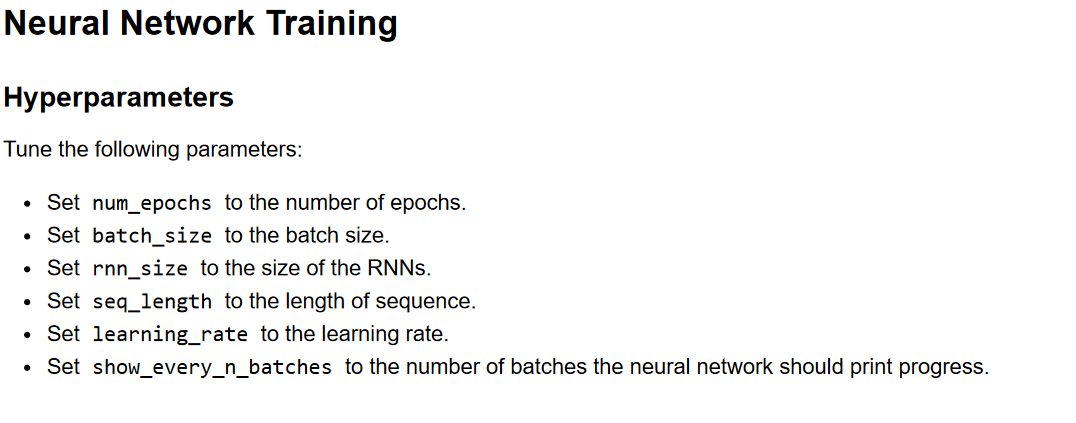

In [35]:
# Number of Epochs
num_epochs=150
# Batch Size
batch_size=128
# RNN Size
rnn_size=128
# Embedding Dimension Size
embed_dim = 256
# Sequence Length
seq_length=32
# Learning Ratel
learning_rate=0.01
# Show stats for every n number of batches
show_every_n_batches=20
save_dir='./save'

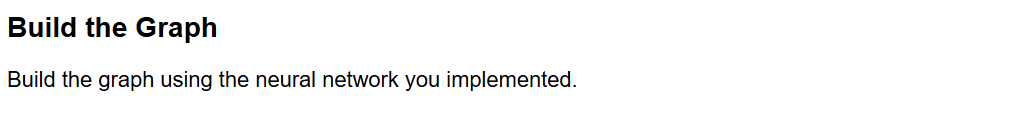

In [33]:
import tensorflow as tf
import warnings
from tensorflow.contrib import seq2seq

warnings.filterwarnings('ignore')

train_graph = tf.Graph()
with train_graph.as_default():
    vocab_size = len(int_to_vocab)
    input_text, targets, lr = get_inputs()
    input_data_shape = tf.shape(input_text)
    cell, initial_state = get_init_cell(input_data_shape[0], rnn_size)
    logits, final_state = build_nn(cell, rnn_size, input_text, vocab_size, embed_dim)

    # Probabilities for generating words
    probs = tf.nn.softmax(logits, name='probs')

    # Loss function
    cost = seq2seq.sequence_loss(
        logits,
        targets,
        tf.ones([input_data_shape[0], input_data_shape[1]]))

    # Optimizer
    optimizer = tf.train.AdamOptimizer(lr)

    # Gradient Clipping
    gradients = optimizer.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    train_op = optimizer.apply_gradients(capped_gradients)

## Train

In [36]:
batches = get_batches(int_text, batch_size, seq_length)

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(num_epochs):
        state = sess.run(initial_state, {input_text: batches[0][0]})

        for batch_i, (x, y) in enumerate(batches):
            feed = {
                input_text: x,
                targets: y,
                initial_state: state,
                lr: learning_rate}
            train_loss, state, _ = sess.run([cost, final_state, train_op], feed)

            # Show every <show_every_n_batches> batches
            if (epoch_i * len(batches) + batch_i) % show_every_n_batches == 0:
                print('Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    epoch_i,
                    batch_i,
                    len(batches),
                    train_loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_dir)
    print('Model Trained and Saved')

Epoch   0 Batch    0/75   train_loss = 9.122
Epoch   0 Batch   20/75   train_loss = 2.290
Epoch   0 Batch   40/75   train_loss = 1.870
Epoch   0 Batch   60/75   train_loss = 1.626
Epoch   1 Batch    5/75   train_loss = 1.431
Epoch   1 Batch   25/75   train_loss = 1.395
Epoch   1 Batch   45/75   train_loss = 1.372
Epoch   1 Batch   65/75   train_loss = 1.370
Epoch   2 Batch   10/75   train_loss = 1.413
Epoch   2 Batch   30/75   train_loss = 1.363
Epoch   2 Batch   50/75   train_loss = 1.328
Epoch   2 Batch   70/75   train_loss = 1.292
Epoch   3 Batch   15/75   train_loss = 1.334
Epoch   3 Batch   35/75   train_loss = 1.310
Epoch   3 Batch   55/75   train_loss = 1.305
Epoch   4 Batch    0/75   train_loss = 1.316
Epoch   4 Batch   20/75   train_loss = 1.297
Epoch   4 Batch   40/75   train_loss = 1.291
Epoch   4 Batch   60/75   train_loss = 1.274
Epoch   5 Batch    5/75   train_loss = 1.298
Epoch   5 Batch   25/75   train_loss = 1.284
Epoch   5 Batch   45/75   train_loss = 1.284
Epoch   5 

Epoch  48 Batch   60/75   train_loss = 0.932
Epoch  49 Batch    5/75   train_loss = 0.963
Epoch  49 Batch   25/75   train_loss = 0.900
Epoch  49 Batch   45/75   train_loss = 0.940
Epoch  49 Batch   65/75   train_loss = 0.908
Epoch  50 Batch   10/75   train_loss = 0.959
Epoch  50 Batch   30/75   train_loss = 0.940
Epoch  50 Batch   50/75   train_loss = 0.924
Epoch  50 Batch   70/75   train_loss = 0.892
Epoch  51 Batch   15/75   train_loss = 0.936
Epoch  51 Batch   35/75   train_loss = 0.923
Epoch  51 Batch   55/75   train_loss = 0.899
Epoch  52 Batch    0/75   train_loss = 0.923
Epoch  52 Batch   20/75   train_loss = 0.890
Epoch  52 Batch   40/75   train_loss = 0.914
Epoch  52 Batch   60/75   train_loss = 0.916
Epoch  53 Batch    5/75   train_loss = 0.928
Epoch  53 Batch   25/75   train_loss = 0.887
Epoch  53 Batch   45/75   train_loss = 0.916
Epoch  53 Batch   65/75   train_loss = 0.909
Epoch  54 Batch   10/75   train_loss = 0.954
Epoch  54 Batch   30/75   train_loss = 0.916
Epoch  54 

Epoch  97 Batch   45/75   train_loss = 0.678
Epoch  97 Batch   65/75   train_loss = 0.635
Epoch  98 Batch   10/75   train_loss = 0.662
Epoch  98 Batch   30/75   train_loss = 0.663
Epoch  98 Batch   50/75   train_loss = 0.686
Epoch  98 Batch   70/75   train_loss = 0.650
Epoch  99 Batch   15/75   train_loss = 0.643
Epoch  99 Batch   35/75   train_loss = 0.689
Epoch  99 Batch   55/75   train_loss = 0.665
Epoch 100 Batch    0/75   train_loss = 0.665
Epoch 100 Batch   20/75   train_loss = 0.632
Epoch 100 Batch   40/75   train_loss = 0.657
Epoch 100 Batch   60/75   train_loss = 0.630
Epoch 101 Batch    5/75   train_loss = 0.640
Epoch 101 Batch   25/75   train_loss = 0.652
Epoch 101 Batch   45/75   train_loss = 0.655
Epoch 101 Batch   65/75   train_loss = 0.629
Epoch 102 Batch   10/75   train_loss = 0.638
Epoch 102 Batch   30/75   train_loss = 0.664
Epoch 102 Batch   50/75   train_loss = 0.673
Epoch 102 Batch   70/75   train_loss = 0.639
Epoch 103 Batch   15/75   train_loss = 0.644
Epoch 103 

Epoch 146 Batch   30/75   train_loss = 0.550
Epoch 146 Batch   50/75   train_loss = 0.575
Epoch 146 Batch   70/75   train_loss = 0.564
Epoch 147 Batch   15/75   train_loss = 0.557
Epoch 147 Batch   35/75   train_loss = 0.564
Epoch 147 Batch   55/75   train_loss = 0.544
Epoch 148 Batch    0/75   train_loss = 0.564
Epoch 148 Batch   20/75   train_loss = 0.536
Epoch 148 Batch   40/75   train_loss = 0.534
Epoch 148 Batch   60/75   train_loss = 0.549
Epoch 149 Batch    5/75   train_loss = 0.525
Epoch 149 Batch   25/75   train_loss = 0.545
Epoch 149 Batch   45/75   train_loss = 0.552
Epoch 149 Batch   65/75   train_loss = 0.523
Model Trained and Saved


### Save Parameters
Save seq length and save dir for generating a new TV script.

In [37]:
save_params((seq_length, save_dir))

## Checkpoint

In [38]:
_, vocab_to_int, int_to_vocab, token_dict = load_preprocess()
seq_length, load_dir = load_params()

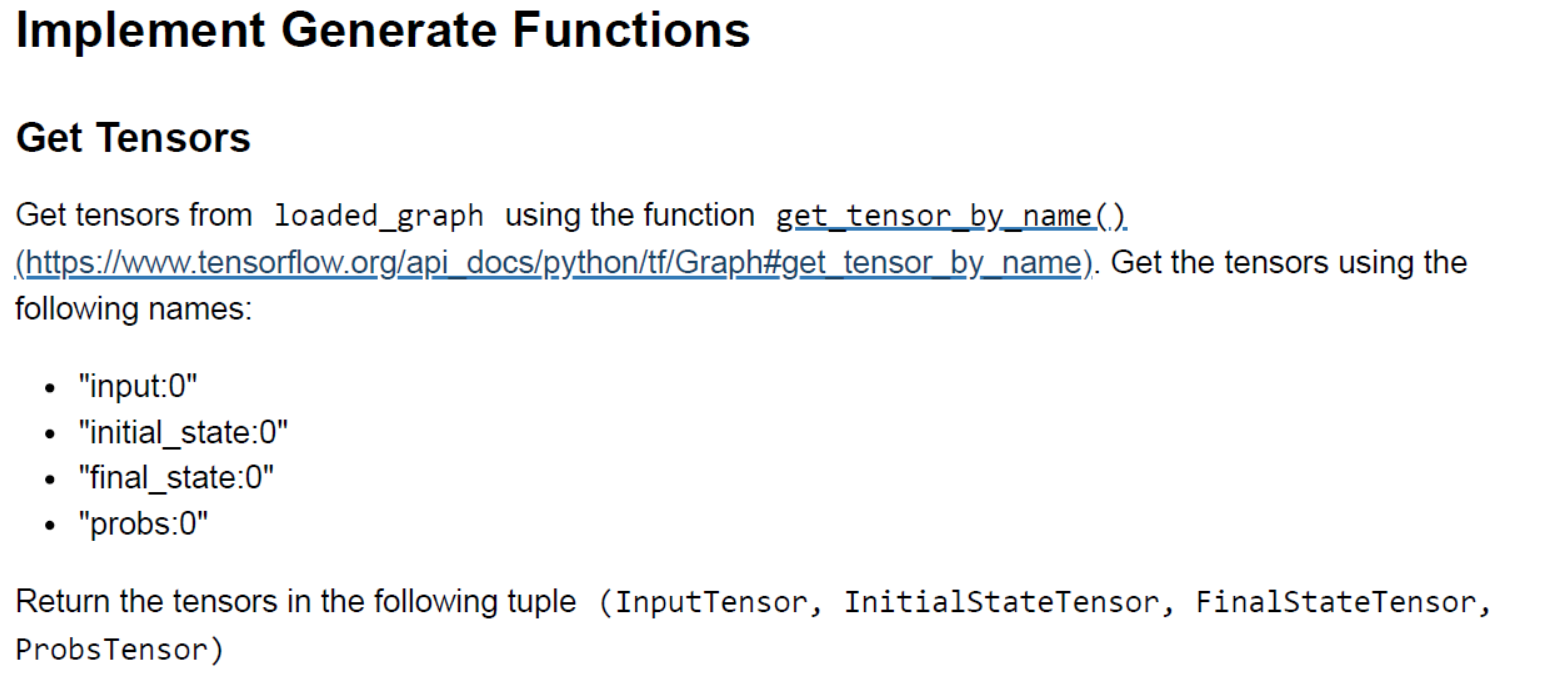

In [39]:
def get_tensors(loaded_graph):
    """
    Get input, initial state, final state, and probabilities tensor from <loaded_graph>
    :param loaded_graph: TensorFlow graph loaded from file
    :return: Tuple (InputTensor, InitialStateTensor, FinalStateTensor, ProbsTensor)
    """
    InputTensor = loaded_graph.get_tensor_by_name("input:0")
    InitialStateTensor = loaded_graph.get_tensor_by_name("initial_state:0")
    FinalStateTensor = loaded_graph.get_tensor_by_name("final_state:0")
    ProbsTensor = loaded_graph.get_tensor_by_name("probs:0")
    return InputTensor, InitialStateTensor, FinalStateTensor, ProbsTensor

In [50]:
def pick_word(probabilities, int_to_vocab):
    """
    Pick the next word in the generated text
    :param probabilities: Probabilites of the next word
    :param int_to_vocab: Dictionary of word ids as the keys and words as the values
    :return: String of the predicted word
    """
    return np.random.choice(list(int_to_vocab.values()),p=probabilities)

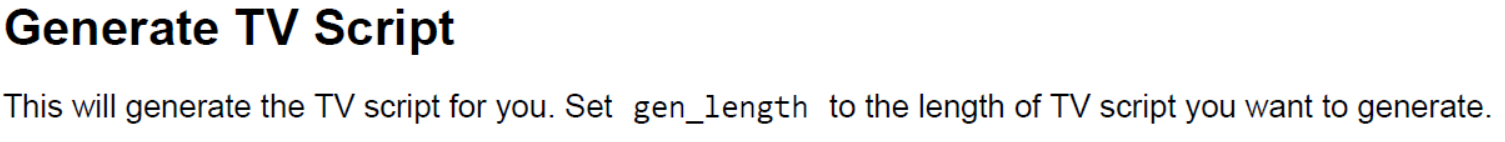

In [61]:
#generate new script
def generate_text(seed_text, num_words, temp=0):
    input_text= seed_text
    for _  in range(num_words):
        #tokenize text to ints
        int_text = helper.tokenize_punctuation(input_text)
        int_text = int_text.lower()
        int_text = int_text.split()
        int_text = np.array([word_to_int[word] for word in int_text], dtype=np.int32)
        #pad text if it is too short, pads with zeros at beginning of text, so shouldnt have too much noise added
        int_text = pad_sequences([int_text], maxlen=sequence_length)
        #predict next word:
        prediction = model.predict(int_text, verbose=0)
        output_word = int_to_word[sample(prediction, temp=temp)]
        #append to the result
        input_text += ' ' + output_word

In [60]:
gen_length = 200

prime_word = 'homer_simpson'

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(save_dir + '.meta')
    loader.restore(sess, save_dir)

    # Get Tensors from loaded model
    input_text, initial_state, final_state, probs = get_tensors(loaded_graph)

    # Sentences generation setup
    gen_sentences = [prime_word + ':']
    prev_state = sess.run(initial_state, {input_text: np.array([[1]])})

    # Generate sentences
    
    for n in range(gen_length):
        # Dynamic Input
        dyn_input = [vocab_to_int[word] for word in gen_sentences[-seq_length:]]]
        dyn_seq_length = len(dyn_input[0])

        # Get Prediction
        probabilities, prev_state = sess.run(
            [probs, final_state],
            {input_text: dyn_input, initial_state: prev_state})
        
        pred_word = pick_word(probabilities[0][dyn_seq_length-1], int_to_vocab)

        gen_sentences.append(pred_word)
    
    # Remove tokens
    tv_script = ' '.join(gen_sentences)
    for key, token in tokenized_punctuation.items():
        ending = ' ' if key in ['\n', '(', '"'] else ''
        tv_script = tv_script.replace(' ' + token.lower(), key)
    tv_script = tv_script.replace('\n ', '\n')
    tv_script = tv_script.replace('( ', '(')
        
    print(tv_script)

NameError: name 'homer_simpson' is not defined

In [62]:
for word in gen_sentences[]:
    dyn_input = vocab_to_int[word] 

KeyError: 'homer_simpson:'

In [57]:
dyn_input

[[]]